In [1]:
from IPython.core.display import display,HTML
display(HTML("<style>.container {width:95% !important;} </style>"))

%load_ext autoreload
%autoreload 2

In [39]:
import os
import re
import pandas as pd
import numpy as np
import shlex
from io import StringIO

from time import perf_counter

from matplotlib import pyplot as plt

In [3]:
from pyelegant.ElegantRun import ElegantRun
from pyelegant.SDDSTools.SDDS import SDDS, SDDSCommand
from pyelegant.SDDSTools.Utils import GenerateNDimCoordinateGrid

In [5]:
sif = "/home/mti/gitlab-hzb/containers/bin/pelegant.sif"

# Creating lattice

In [6]:
elements ={
    "QF":{
        "type" : "KQUAD",
        "L": 0.342,
        "K1": 0.49,
        "N_KICKS":16
    },
    "QD":{
        "type" : "KQUAD",
        "L": 0.668,
        "K1": -0.4999,
        "N_KICKS":16
    },
    "D":{
        "type" : "DRIF",
     "L":3.5805   
    },
    "W1": {
        "type": "WATCH",
        "filename":"\"%s-%03ld.w1\"",
        "mode": "coordinates"
    }
}

FODOstr = "! FODO cell used by Jernej Frank for studying TRIBs\n\n"
stringlist = ["{:6}: {}".format(k,", ".join(["{}={:15.12f}".format(kk,vv) 
                                             if not isinstance(vv,str)
                                             else "{}={}".format(kk,vv)
                                             if kk!="type" else "{}".format(vv) for kk,vv in v.items()])) 
              for k,v in elements.items()]
line = ["W1","QF","D","QD","D","QF"]
linestr = "{:6}: LINE=({})".format("FODO",",".join(line))
FODOstr += "\n".join(stringlist)
FODOstr += "\n\n"
FODOstr += linestr

In [7]:
print(FODOstr)

! FODO cell used by Jernej Frank for studying TRIBs

QF    : KQUAD, L= 0.342000000000, K1= 0.490000000000, N_KICKS=16.000000000000
QD    : KQUAD, L= 0.668000000000, K1=-0.499900000000, N_KICKS=16.000000000000
D     : DRIF, L= 3.580500000000
W1    : WATCH, filename="%s-%03ld.w1", mode=coordinates

FODO  : LINE=(W1,QF,D,QD,D,QF)


In [8]:
with open("FODO_Jernej.lte","w") as f:
    f.write(FODOstr)

In [9]:
lattice = "FODO_Jernej.lte"

# Running simulations and plotting

In [10]:
# setup elegant simulator
er = ElegantRun(sif,lattice, parallel=True, use_beamline="FODO", energy=1700.00)

In [14]:
twidata, twipar = er.findtwiss()

In [15]:
twipar.index

Index(['Step', 'nux', 'dnux/dp', 'dnux/dp2', 'dnux/dp3', 'Ax', 'AxLocation',
       'nuy', 'dnuy/dp', 'dnuy/dp2', 'dnuy/dp3', 'Ay', 'AyLocation',
       'deltaHalfRange', 'nuxChromUpper', 'nuxChromLower', 'nuyChromUpper',
       'nuyChromLower', 'pCentral', 'dbetax/dp', 'dbetay/dp', 'dalphax/dp',
       'dalphay/dp', 'etax2', 'etay2', 'etax3', 'etay3', 'etaxp2', 'etayp2',
       'etaxp3', 'etayp3', 'betaxMin', 'betaxAve', 'betaxMax', 'betayMin',
       'betayAve', 'betayMax', 'etaxMax', 'etayMax', 'waistsx', 'waistsy',
       'dnux/dAx', 'dnux/dAy', 'dnuy/dAx', 'dnuy/dAy', 'dnux/dAx2',
       'dnux/dAy2', 'dnux/dAxAy', 'dnuy/dAx2', 'dnuy/dAy2', 'dnuy/dAxAy',
       'nuxTswaLower', 'nuxTswaUpper', 'nuyTswaLower', 'nuyTswaUpper',
       'couplingIntegral', 'couplingDelta', 'emittanceRatio', 'alphac2',
       'alphac', 'I1', 'I2', 'I3', 'I4', 'I5', 'ex0', 'enx0', 'taux', 'Jx',
       'tauy', 'Jy', 'Sdelta0', 'taudelta', 'Jdelta', 'U0', 'length'],
      dtype='object', name='ParameterName'

In [16]:
twipar.pCentral, twipar.I2

(3326.816, 0.0)

In [17]:
tup = er.find_matrices(SDDS_output_order=4)

In [18]:
delta = 1.5e-3 * twipar.pCentral
delta

4.9902239999999995

In [19]:
twipar.pCentral + delta 

3331.806224

## Setting up initial coord grids

In [34]:
man_ranges_px0 = {
    0 : np.array([0,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.95,1.975,1.9875,2,2.1,2.2,2.3]),
    1 : [0], #0.05
    2 : 0,
    3 : 0,
    4 : 0,
    5 : twipar.pCentral + delta 
}

man_ranges_px0p05 = {
    0 : np.array([0,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.95,1.975,1.9875,2,2.1,2.2,2.3]),
    1 : [0.05], #0.05
    2 : 0,
    3 : 0,
    4 : 0,
    5 : twipar.pCentral + delta 
}

man_ranges_lim = {
    0 : np.array([1.7,1.8,1.9,1.95,1.975,1.9875]),
    1 : [0.05], #0.05
    2 : 0,
    3 : 0,
    4 : 0,
    5 : twipar.pCentral + delta 
}

## Running sims and plot

In [25]:
er.generate_sdds_particle_inputfile(man_ranges=man_ranges_px0)
er.track_simple(n_passes=1000)

Shape: (24, 6) - Number of paritcles: 24 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount
bash run_pelegant.sh
bash run_pelegant.sh temp.ele


In [29]:
# if you want to check input 
# parallel elegant
sddsinput = SDDS(sif, "temp_particles_input.bin",0)
# serial 
#sddsinput = SDDS(sif, "temp_particles_input.txt",1)
sddsinput.getColumnValues()

,x,xp,y,yp,t,p,particleID
0,0.000000,0.0,0.0,0.0,0.0,3331.806224,1
1,0.000001,0.0,0.0,0.0,0.0,3331.806224,2
2,0.000010,0.0,0.0,0.0,0.0,3331.806224,3
3,0.000100,0.0,0.0,0.0,0.0,3331.806224,4
4,0.001000,0.0,0.0,0.0,0.0,3331.806224,5
5,0.010000,0.0,0.0,0.0,0.0,3331.806224,6
6,0.100000,0.0,0.0,0.0,0.0,3331.806224,7
7,1.000000,0.0,0.0,0.0,0.0,3331.806224,8
8,1.100000,0.0,0.0,0.0,0.0,3331.806224,9
9,1.200000,0.0,0.0,0.0,0.0,3331.806224,10


In [26]:
sddsp = SDDS(sif,"temp-001.w1",0)

# saving plot to file
sddsp.sddsplot_base(
    columnNames="x,xp",
    file="temp-001.w1",
    scale="0,0,0,0",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID",
    device="gif",
    output="FODO_island_init_px_zero.gif"
)

# showing plot
sddsp.sddsplot_base(
    columnNames="x,xp",
    file="temp-001.w1",
    scale="0,0,0,0",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID"
)

Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -columnNames=x,xp temp-001.w1 -scale=0,0,0,0 -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID -device=gif -output=FODO_island_init_px_zero.gif
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -columnNames=x,xp temp-001.w1 -scale=0,0,0,0 -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID


In [30]:
er.generate_sdds_particle_inputfile(man_ranges=man_ranges_px0p05)
er.track_simple(n_passes=1000)

sddsp = SDDS(sif,"temp-001.w1",0)

# saving plot to file
sddsp.sddsplot_base(
    columnNames="x,xp",
    file="temp-001.w1",
    scale="0,0,0,0",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID",
    device="gif",
    output="FODO_island_init_px_not_zero.gif"
)

# showing plot
sddsp.sddsplot_base(
    columnNames="x,xp",
    file="temp-001.w1",
    scale="0,0,0,0",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID"
)

Shape: (24, 6) - Number of paritcles: 24 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount
bash run_pelegant.sh
bash run_pelegant.sh temp.ele
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -columnNames=x,xp temp-001.w1 -scale=0,0,0,0 -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID -device=gif -output=FODO_island_init_px_not_zero.gif
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -columnNames=x,xp temp-001.w1 -scale=0,0,0,0 -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID


In [43]:
st = perf_counter()
er.generate_sdds_particle_inputfile(man_ranges=man_ranges_lim)
er.track_simple(n_passes=1_000_000)

sddsp = SDDS(sif,"temp-001.w1",0)

# saving plot to file
sddsp.sddsplot_base(
    columnNames="x,xp",
    file="temp-001.w1",
    scale="0,0,0,0",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID",
    device="gif",
    output="FODO_island_init_px_not_zero_long.gif"
)

# # showing plot
# sddsp.sddsplot_base(
#     columnNames="x,xp",
#     file="temp-001.w1",
#     scale="0,0,0,0",
#     graph="symb,vary=subtype,fill",
#     order="spectral",
#     split="columnBin=particleID"
# )

print()
print("Took :",perf_counter() - st)

Shape: (6, 6) - Number of paritcles: 6 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount
bash run_pelegant.sh
bash run_pelegant.sh temp.ele
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -columnNames=x,xp temp-001.w1 -scale=0,0,0,0 -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID -device=gif -output=FODO_island_init_px_not_zero_long.gif

Took : 699.9896064960049


In [44]:
# showing plot
sddsp.sddsplot_base(
    columnNames="x,xp",
    file="temp-001.w1",
    scale="0,0,0,0",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID"
)


Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -columnNames=x,xp temp-001.w1 -scale=0,0,0,0 -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID


# Reading the particle tracking data - be careful with large files (memory)

In [47]:
pdata = sddsp.readParticleData()

False
temp-001.w1.txt
temp-001.w1.txt
['x', 'xp', 'y', 'yp', 't', 'p', 'dt', 'particleID']
File is large, output redirected to file temp-001.w1.txt_columnvalues.dat


In [60]:
df = pdata.groupby("particleID").get_group(1).compute()

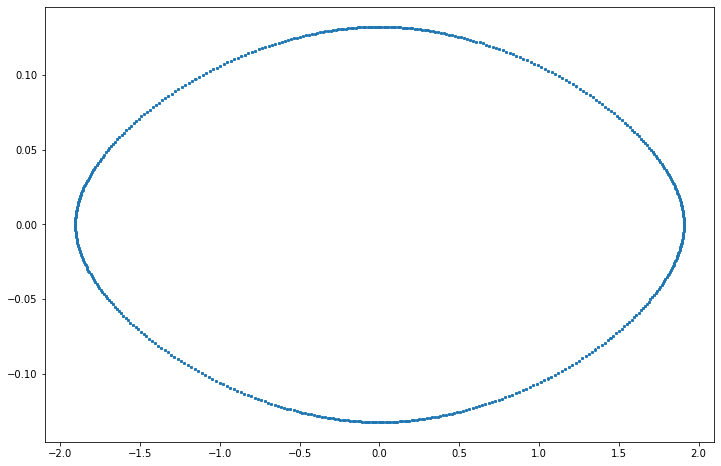

In [61]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12,8))
plt.scatter(df.x[::100],df.xp[::100],s=1)
plt.savefig("elliptic.png")

In [62]:
df = pdata.groupby("particleID").get_group(2).compute()

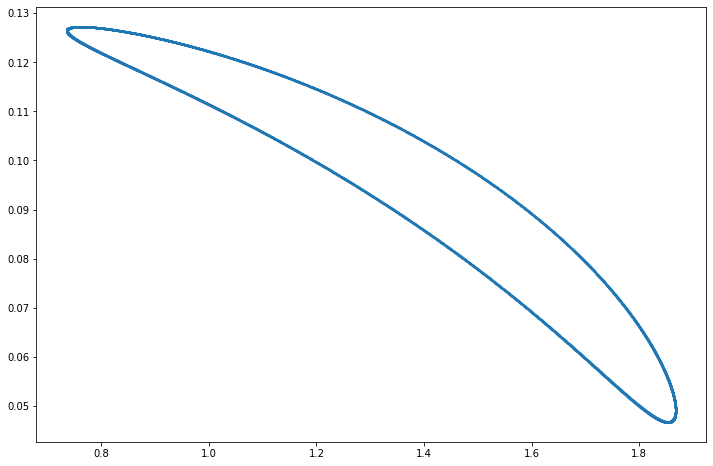

In [63]:
fig = plt.figure(figsize=(12,8))
plt.scatter(df.x[::100],df.xp[::100],s=1)
plt.savefig("island.png")